# Branch and Bound

Branch and Bound is an algorithm design paradigm for discrete and combinatorial optimization problems. It is used to solve problems where the solution space is large and cannot be exhaustively searched. The algorithm works by dividing the problem into smaller subproblems (branching) and calculating an upper and lower bound for the objective function in these subproblems. If the lower bound of a subproblem is greater than the upper bound of another, the subproblem can be discarded (pruning). This process continues until the optimal solution is found. Branch and Bound is commonly used in solving problems like the Traveling Salesman Problem, Knapsack Problem, and Integer Programming.

## An illustrative example

To illustrate the Branch and Bound algorithm, let's consider a small example with 3 variables:

1. **Objective Function**: Maximize $ z = 3x_1 + 2x_2 + x_3 $
2. **Constraints**:
    - $ 7x_1 + 3x_2 + 4x_3 \leq 50 $
    - $ 5x_1 + 4x_2 \leq 40 $   
    - $ x_1, x_2, x_3 \geq 0 $
    - $ x_1, x_2, x_3 $ are integers

We start by solving the linear relaxation of the problem (ignoring the integer constraints) and then use the Branch and Bound method to find the optimal integer solution.

## Setting the Environment

In [1]:
%pip install matplotlib pandas numpy pulp networkx graphviz pydot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pulp as pl
import networkx as nx
import pydot, graphviz


# Define the problem
prob = pl.LpProblem("Maximize_Z", pl.LpMaximize)

# Define the variables
x1 = pl.LpVariable('x1', lowBound=0, cat='Integer')
x2 = pl.LpVariable('x2', lowBound=0, cat='Integer')
x3 = pl.LpVariable('x3', lowBound=0, cat='Integer')

# Define the objective function
prob += 3*x1 + 2*x2 + x3, "Objective"

# Define the constraints
prob += 7*x1 + 3*x2 + 4*x3 <= 50, "Constraint 1"
prob += 5*x1 + 3*x2 <= 40, "Constraint 2"

# Solve the problem
prob.solve()

# Print the results
print(f"Status: {pl.LpStatus[prob.status]}")
print(f"x1 = {pl.value(x1)}")
print(f"x2 = {pl.value(x2)}")
print(f"x3 = {pl.value(x3)}")
print(f"Objective = {pl.value(prob.objective)}")

Note: you may need to restart the kernel to use updated packages.
Status: Optimal
x1 = 0.0
x2 = 13.0
x3 = 2.0
Objective = 28.0


## Branch and Bound Algorithm

### Setting the Environment

In [2]:
# Linear relaxation
x1.cat = 'Continuous'
x2.cat = 'Continuous'
x3.cat = 'Continuous'


# Define a class to store node information
class Node:
    def __init__(self, name, parent, prob):
        self.name = name
        self.new_constraints = 'None'
        self.parent = parent
        self.prob = prob
        self.solution = dict()
        self.status = 'pending'
        
# The Best Node so far
BestNode = None 

# Define the node list
node_list = []

# Define a function to solve the node, update the status, and return the node
def solve_node(node):
    global BestNode
    node.prob.solve(pl.PULP_CBC_CMD(msg=0))
    
    lpstatus = pl.LpStatus[node.prob.status]
    
    if lpstatus == 'Optimal':
        for var in node.prob.variables():
            node.solution[var.name] = var.varValue
        node.solution['z'] = node.prob.objective.value()
        if(BestNode != None and node.prob.objective.value() <= BestNode.prob.objective.value()):
            node.status = 'pruned'
        else:
            # We check if all the variables are integer
            all_int = True
            for var in node.prob.variables():
                if var.varValue != int(var.varValue):
                    all_int = False
                    break
            if all_int:
                if BestNode == None or node.prob.objective.value() > BestNode.prob.objective.value():
                    BestNode = node
                    print(f"Best Node: {node.name}")
                   
                node.status = 'integer'
            else:
                node.status = 'fractional'  
    elif lpstatus == 'Infeasible':
        node.status = 'infeasible'
    else:
        node.status = 'unknown'
    
    return node.status

# Define a function to create a child nodes
def create_child_nodes(parent_node):
    child_nodes = []
    
    if parent_node.status == 'integer' or parent_node.status == 'infeasible' or parent_node.status == 'pruned':
        return child_nodes
    
    # Select the variable to branch on
    max_fractionality = 0
    branch_var = None
    for var in parent_node.prob.variables():
        if var.varValue != int(var.varValue):
            fractionality = var.varValue - int(var.varValue)
            if fractionality > max_fractionality:
                max_fractionality = fractionality
                branch_var = var
    
    # Create the child nodes
    for i in range(2):
        child_prob = parent_node.prob.copy()
        child_name = parent_node.name + f".{i}"
        if(parent_node.name == 'Root'):
            child_name = f"Node.{i}"
        cut = None
        if i == 1:
            cut = branch_var <= int(branch_var.varValue)
        else:
            cut = branch_var >= int(branch_var.varValue) + 1
        child_prob += cut
        child_node = Node(child_name, parent_node, child_prob)
        child_node.new_constraints = cut.__str__()
        child_nodes.append(child_node)
    return child_nodes
    
   
# Define a function to create and plot the branch and bound tree
def plot_tree(node_list):
    G = nx.DiGraph()
    for node in node_list:
        label = f"{node.name}"
        if node.new_constraints != 'None':
            label += f"\n{node.new_constraints}"
        for name, value in node.solution.items():
            label += f"\n{name}={value:.2f}"
        label += f"\n{node.status}"
        G.add_node(node.name, label=label)
        if node.parent != None:
            G.add_edge(node.parent.name, node.name)
    pos = nx.drawing.nx_pydot.pydot_layout(G, prog='dot')
    labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, labels=labels)
    nx.draw_networkx_nodes(G, pos, node_shape='s', node_size=5000, node_color='lightblue')
    plt.show()
    
    


## The Root Node and its Two Children

In [3]:
RootNode = Node("Root", None, prob)
node_list.append(RootNode)

solve_node(RootNode)

childs = create_child_nodes(RootNode)

for child in childs:
    node_list.append(child)
    
plot_tree(node_list)

FileNotFoundError: [WinError 2] "dot" not found in path.

## The Complete Exploration

Best Node: Node.1.1.1
Best Node: Node.1.1.1
x1 = 0.0
x2 = 13.0
x3 = 2.0
z = 28.0


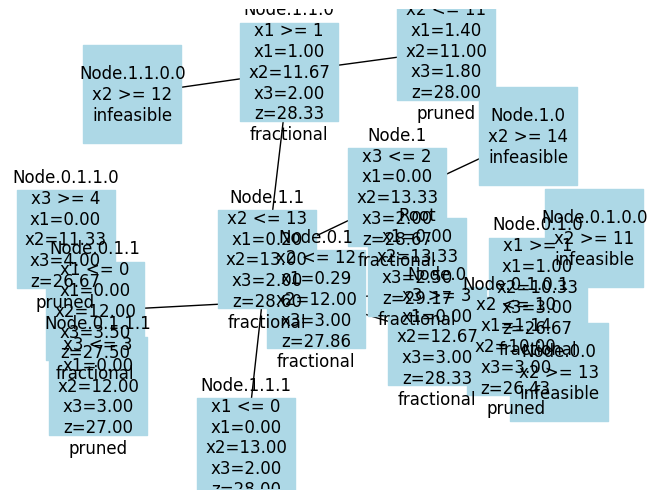

In [125]:
while any(node.status == 'pending' for node in node_list):
    for node in node_list:
        if node.status == 'pending':
            solve_node(node)
            childs = create_child_nodes(node)
            node_list.extend(childs)
            break

print(f"Best Node: {BestNode.name}")
for name, var in BestNode.solution.items():
    print(f"{name} = {var}")
plot_tree(node_list)